# Select 1D slices of a 2D dataset

Use custom callback functions to perform arbitrary tasks on the data when clicking on the map.

- Identify clicked row/col in a 2D dataset
- Highlight the found row and column using a new layer

(requires EOmaps >= v3.1.4)

![image](../../../_static/example_images/example_row_col_selector.gif)


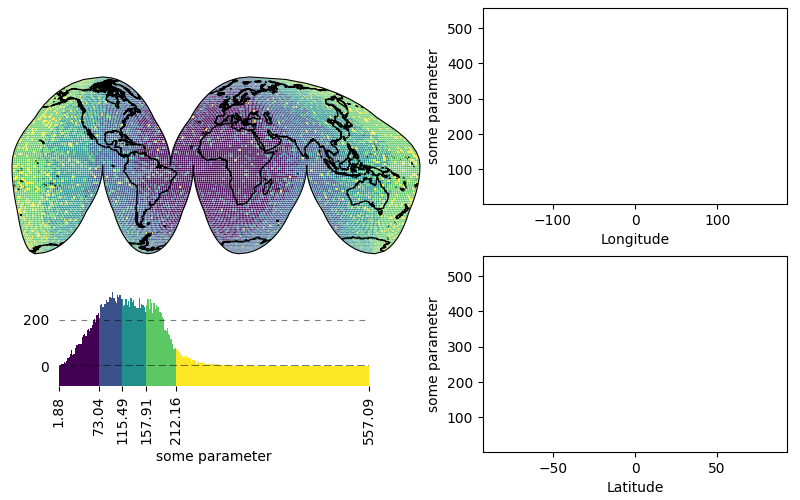

In [1]:
# EOmaps example: Select 1D slices of a 2D dataset

from eomaps import Maps
import numpy as np

# setup some random 2D data
lon, lat = np.meshgrid(np.linspace(-180, 180, 200), np.linspace(-90, 90, 100))
data = np.sqrt(lon**2 + lat**2) + np.random.normal(size=lat.shape) ** 2 * 20
name = "some parameter"
# ----------------------

# create a new map spanning the left row of a 2x2 grid
m = Maps(crs=Maps.CRS.InterruptedGoodeHomolosine(), ax=(2, 2, (1, 3)), figsize=(8, 5))
m.add_feature.preset.coastline()
m.set_data(data, lon, lat, parameter=name)
m.set_classify_specs(Maps.CLASSIFIERS.NaturalBreaks, k=5)
m.plot_map()

# create 2 ordinary matplotlib axes to show the selected data
ax_row = m.f.add_subplot(222)  # 2x2 grid, top right
ax_row.set_xlabel("Longitude")
ax_row.set_ylabel(name)
ax_row.set_xlim(-185, 185)
ax_row.set_ylim(data.min(), data.max())

ax_col = m.f.add_subplot(224)  #  2x2 grid, bottom right
ax_col.set_xlabel("Latitude")
ax_col.set_ylabel(name)
ax_col.set_xlim(-92.5, 92.5)
ax_col.set_ylim(data.min(), data.max())

# add a colorbar for the data
m.add_colorbar(label=name)
m.colorbar.ax_cb.tick_params(rotation=90)  # rotate colorbar ticks 90°

# add new layers to plot row- and column data
m2 = m.new_layer()
m2.set_shape.ellipses(m.shape.radius)

m3 = m.new_layer()
m3.set_shape.ellipses(m.shape.radius)


# define a custom callback to indicate the clicked row/column
def cb(m, ind, ID, *args, **kwargs):
    # get row and column from the data
    # NOTE: "ind" always represents the index of the flattened array!
    r, c = np.unravel_index(ind, m.data.shape)

    # ---- highlight the picked column
    # use "dynamic=True" to avoid re-drawing the background on each pick
    # use "set_extent=False" to avoid resetting the plot extent on each draw
    m2.set_data(m.data_specs.data[:, c], m.data_specs.x[:, c], m.data_specs.y[:, c])
    m2.plot_map(fc="none", ec="b", set_extent=False, dynamic=True)

    # ---- highlight the picked row
    m3.set_data(m.data_specs.data[r, :], m.data_specs.x[r, :], m.data_specs.y[r, :])
    m3.plot_map(fc="none", ec="r", set_extent=False, dynamic=True)

    # ---- plot the data for the selected column
    (art0,) = ax_col.plot(m.data_specs.y[:, c], m.data_specs.data[:, c], c="b")
    (art01,) = ax_col.plot(
        m.data_specs.y[r, c],
        m.data_specs.data[r, c],
        c="k",
        marker="o",
        markerfacecolor="none",
        ms=10,
    )

    # ---- plot the data for the selected row
    (art1,) = ax_row.plot(m.data_specs.x[r, :], m.data_specs.data[r, :], c="r")
    (art11,) = ax_row.plot(
        m.data_specs.x[r, c],
        m.data_specs.data[r, c],
        c="k",
        marker="o",
        markerfacecolor="none",
        ms=10,
    )

    # make all artists temporary (e.g. remove them on next pick)
    # "m2.coll" represents the collection created by "m2.plot_map()"
    for a in [art0, art01, art1, art11, m2.coll, m3.coll]:
        m.cb.pick.add_temporary_artist(a)


# attach the custom callback
m.cb.pick.attach(cb, m=m)


# ---- add a pick-annotation with a custom text
def text(ind, val, **kwargs):
    r, c = np.unravel_index(ind, m.data.shape)
    return (
        f"row/col = {r}/{c}\n"
        f"lon/lat = {m.data_specs.x[r, c]:.2f}/{m.data_specs.y[r, c]:.2f}\n"
        f"val = {val:.2f}"
    )


m.cb.pick.attach.annotate(text=text, fontsize=7)

# apply a previously arranged layout (e.g. check "layout-editor" in the docs!)
m.apply_layout(
    {
        "figsize": [8, 5],
        "0_map": [0.015, 0.49253, 0.51, 0.35361],
        "1_": [0.60375, 0.592, 0.38, 0.392],
        "2_": [0.60375, 0.096, 0.38, 0.392],
        "3_cb": [0.025, 0.144, 0.485, 0.28],
        "3_cb_histogram_size": 0.8,
    }
)
m.show()